In [2]:
!git clone https://github.com/AntonioSkara132/LangPathModel.git

Cloning into 'LangPathModel'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 183 (delta 6), reused 10 (delta 3), pack-reused 165 (from 1)
Receiving objects: 100% (183/183), 98.53 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (82/82), done.


# 1. Loading Dataset

In [4]:
import torch
import torch.utils

from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

scale = 1000

class CirclePathDataset(Dataset):
    def __init__(self, file_path):
        # Load the data from the .pt file
        self.data = torch.load(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the path tensor and the text for the given index
        path_tensor = self.data[idx]['path'].clone()
        path_tensor[:, 0:2] /= scale
        text = self.data[idx]['text']
        return path_tensor, text


from torch.nn.utils.rnn import pad_sequence
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def collate_fn(batch):
    # Unzip the batch into paths and texts
    paths, texts = zip(*batch)
    # Pad the paths (ensure they're all the same length)
    padded_paths = pad_sequence(paths, batch_first=True, padding_value=0)  # Padding value can be set to 0

    encoded = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

    return padded_paths, encoded


# Instantiate the dataset
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle_num_p_20.pt")

# Create a DataLoader with the custom collate_fn

# 2. Visualizing Dataset

In [7]:
import torch
import numpy as np

# Assuming you already loaded your dataset
#dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle_num_p_20.pt")

# Containers for analysis
path_lengths = []
positions = []
actions = []
stops = []

for path, _ in dataset:
    path_lengths.append(path.shape[0])  # Sequence length
    path_np = path.numpy()

    positions.extend(path_np[:, :2])  # x, y
    actions.extend(path_np[:, 2])      # a
    stops.extend(path_np[:, 3])      # s

positions = np.array(positions)
actions = np.array(actions)
stops = np.array(stops)

# Summary stats
print(f"Number of samples: {len(dataset)}")
print(f"Avg. path length: {np.mean(path_lengths):.2f}")
print(f"Max path length: {np.max(path_lengths)}")
print(f"Min path length: {np.min(path_lengths)}")
print(f"Position X: mean={positions[:,0].mean():.2f}, std={positions[:,0].std():.2f}")
print(f"Position Y: mean={positions[:,1].mean():.2f}, std={positions[:,1].std():.2f}")
print(f"Actions (a): mean={actions.mean():.2f}, std={actions.std():.2f}")
print(f"Stop (s): mean={stops.mean():.2f}, std={stops.std():.2f}")


Number of samples: 10000
Avg. path length: 45.21
Max path length: 52
Min path length: 40
Position X: mean=0.50, std=0.10
Position Y: mean=0.50, std=0.10
Actions (a): mean=0.84, std=0.37
Stop (s): mean=0.02, std=0.15


tensor([[0.8730, 0.6290, 0.0000, 0.0000],
        [0.8251, 0.6147, 0.0000, 0.0000],
        [0.7772, 0.6004, 0.0000, 0.0000],
        [0.7293, 0.5861, 0.0000, 0.0000],
        [0.6814, 0.5718, 0.0000, 0.0000],
        [0.6335, 0.5575, 0.0000, 0.0000],
        [0.5896, 0.5444, 0.0000, 0.0000],
        [0.5896, 0.5444, 1.0000, 0.0000],
        [0.5703, 0.5711, 1.0000, 0.0000],
        [0.5703, 0.5711, 1.0000, 0.0000],
        [0.5435, 0.5901, 1.0000, 0.0000],
        [0.5435, 0.5901, 1.0000, 0.0000],
        [0.5119, 0.5993, 1.0000, 0.0000],
        [0.5119, 0.5993, 1.0000, 0.0000],
        [0.4790, 0.5978, 1.0000, 0.0000],
        [0.4790, 0.5978, 1.0000, 0.0000],
        [0.4484, 0.5856, 1.0000, 0.0000],
        [0.4484, 0.5856, 1.0000, 0.0000],
        [0.4234, 0.5642, 1.0000, 0.0000],
        [0.4234, 0.5642, 1.0000, 0.0000],
        [0.4067, 0.5359, 1.0000, 0.0000],
        [0.4067, 0.5359, 1.0000, 0.0000],
        [0.4001, 0.5036, 1.0000, 0.0000],
        [0.4001, 0.5036, 1.0000, 0

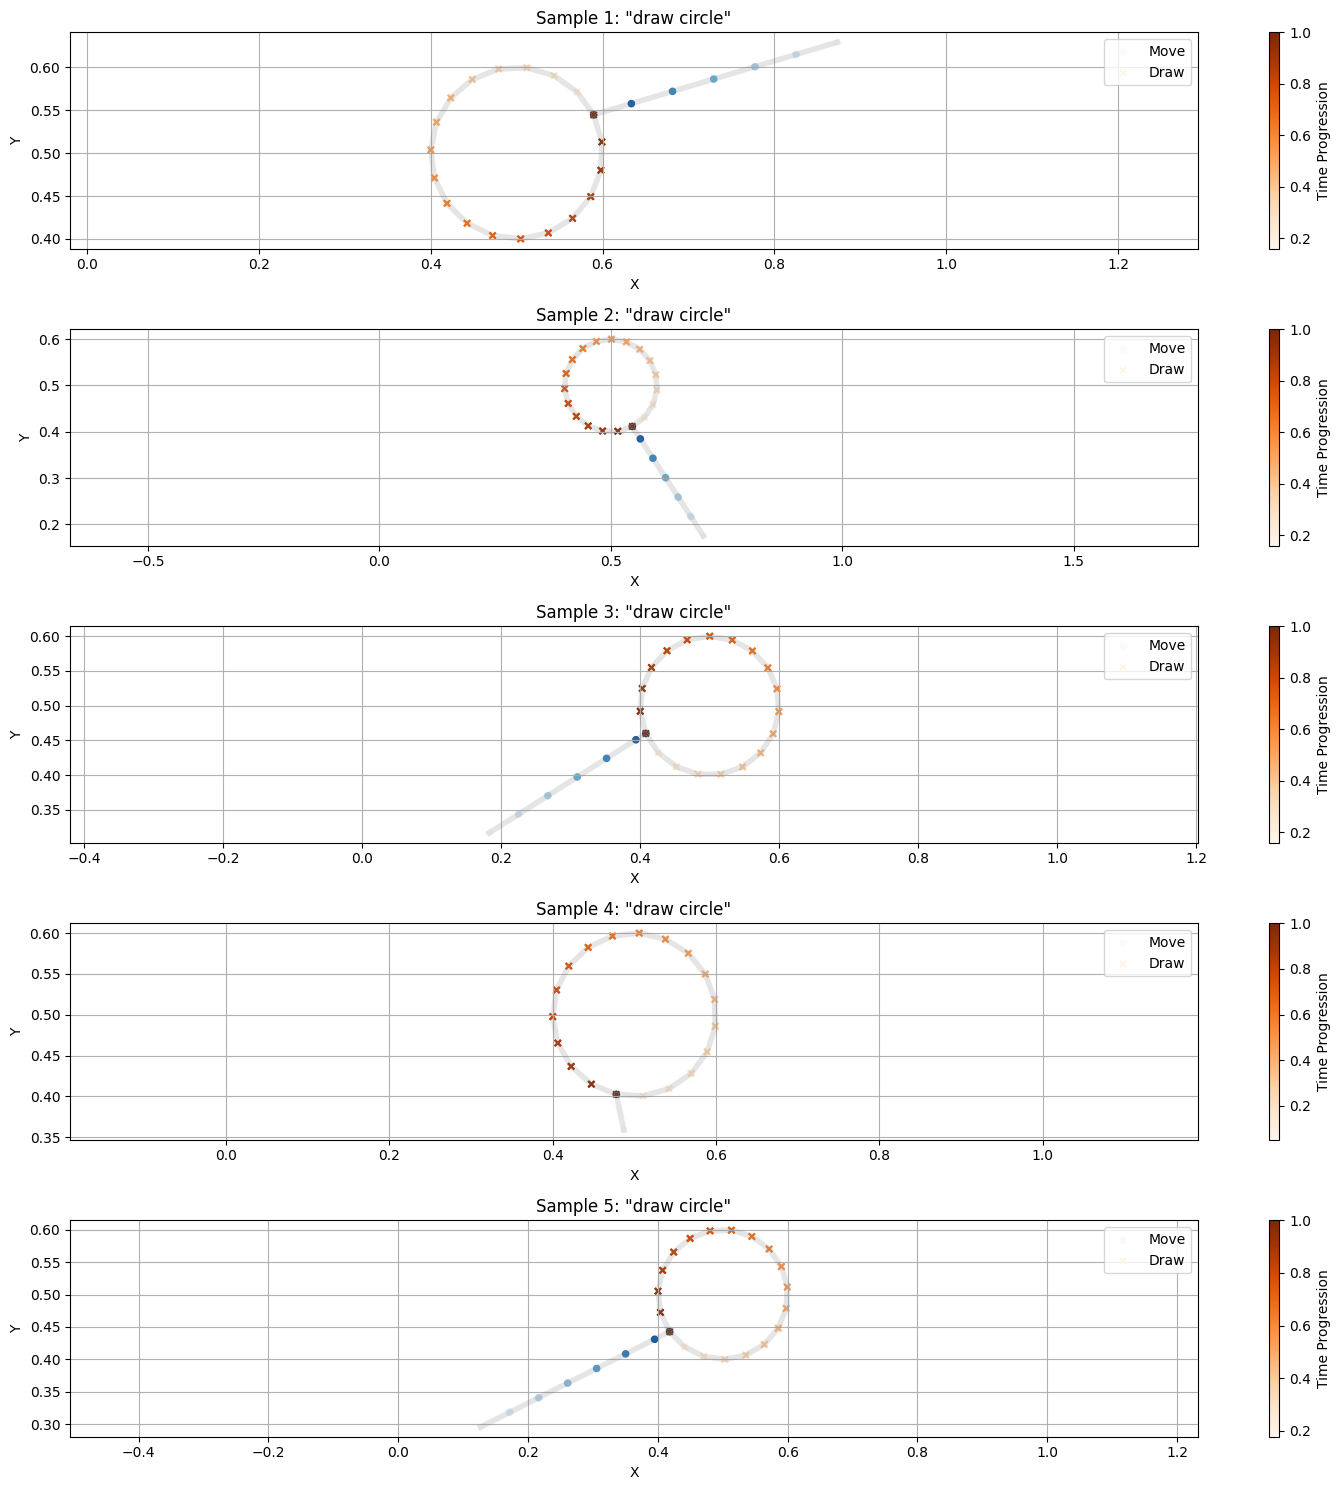

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize a few paths
num_to_plot = 5
plt.figure(figsize=(15, 3 * num_to_plot))

for i in range(num_to_plot):
    path, text = dataset[i]
    path_np = path.numpy()
    print(path)
    x, y = path_np[:, 0], path_np[:, 1]
    actions = path_np[:, 2]
    time = np.linspace(0, 1, len(x))

    plt.subplot(num_to_plot, 1, i + 1)

    # Separate by action
    move_mask = actions == 0
    draw_mask = actions == 1

    # Plot move points
    move = plt.scatter(x[move_mask], y[move_mask], c=time[move_mask], cmap='Blues', marker='o', s=20, label="Move")
    # Plot draw points
    draw = plt.scatter(x[draw_mask], y[draw_mask], c=time[draw_mask], cmap='Oranges', marker='x', s=20, label="Draw")

    # Optionally plot light path line in background
    plt.plot(x, y, linewidth=4, alpha=0.2, color='gray')

    plt.title(f"Sample {i + 1}: \"{text}\"")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(draw, label="Time Progression")  # You can use `move` or `draw`, both have color info
    plt.axis("equal")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# 3. Training

In [9]:
import torch
from LangPathModel.colab_src.nn import TrajectoryModel
from LangPathModel.colab_src.textEncoders import TextEncoder
from torch.optim.lr_scheduler import StepLR

#data = [Batch, sequence, (batch input, batch target)]

def train(model, dataloader, niter, device, start_lr = 1e-4):
    criterion = model.get_loss  # assumes it returns CrossEntropyLoss with ignore_index for padding
    optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
    num_batches = len(dataloader)
    #print(f"Number of batches: {num_batches}")
    Scheduler = StepLR(optimizer, step_size = 3, gamma=0.1)
    model.positional_encoding = model.positional_encoding.to(device)
    # The model is already defined outside the train function, no need to redefine it here
    # model = TrajectoryModel()
    model.train()
    #text_encoder = TextEncoder(output_dim=model.d_model)
    #text_encoder.to(device) # Move text_encoder to the device

    for epoch in range(niter):
        total_loss = 0
        index = 0
        for batch_paths, batch_texts in dataloader:
            #print(f"paths: {batch_paths[0]}")
            batch_paths = batch_paths.to(device).float()
            #print(type(batch_paths))
            # Shift target for teacher forcing
            decoder_input = batch_paths[:, :-1].to(device)      # all except last token, move to device
            target_output = batch_paths[:, 1:].to(device)        # all except first token, move to device
            encoder_input = batch_paths[:, 0].unsqueeze(1).to(device) # Move encoder_input to the device
            #print(target_output)

            encoder_input_mask = (encoder_input.abs().sum(dim=-1) != 0).bool().reshape(-1, 1).to(device)
            #print(f"encoder_input_mask: {encoder_input_mask.shape}")
            #print(f"encoder_input: {encoder_input.shape}"
            #emb_text = text_encoder(batch_texts['input_ids'].to(device), batch_texts['attention_mask'].to(device)) # Pass tensors on the device
            text_mask = batch_texts['attention_mask'] == 0
            text = batch_texts['input_ids']
            optimizer.zero_grad()
            #print(f"encoder input mask: {encoder_input_mask.shape}")
            #print(f"encoder_input: {encoder_input.shape}")

            text = text.to(device).long()
            text_mask = text_mask.to(device).bool()

            predictions = model(text = text, path = encoder_input, path_mask = encoder_input_mask, tgt = decoder_input, text_mask=text_mask)  # shape: [B, T]
            # Reshape for loss: CrossEntropy wants [B*T, vocab_size] vs [B*T]

            #predictions = predictions.reshape(-1, predictions.size(-1))
            #print("predictions:", predictions.shape)        # should be [32, 199, 512]
            #print("target_output:", target_output.shape)    # should be the same

            loss = criterion(predictions, target_output)#fix this
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            #print(loss.item())
            #print(index)


        Scheduler.step()
        print(f"Epoch {epoch+1} | Loss: {(total_loss/num_batches):.4f}")



In [36]:
import torch
import torch.utils

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from LangPathModel.colab_src.nn import TrajectoryModel

#from LangPathModel.colab_src.dataset_preprocessing import CirclePathDataset, collate_fn

# Instantiate the dataset
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle.pt")


# Create a DataLoader with the custom collate_fn
dataloader = DataLoader(dataset, batch_size=50, collate_fn=collate_fn, shuffle=True)

model = TrajectoryModel(d_model = 128, num_heads_decoder = 4, num_decoder_layers = 4)
#print(model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
for name, param in model.named_parameters():
    print(f"{name}: {param.device}")


train(model = model, niter = 12, dataloader = dataloader, device = device, start_lr = 1e-4)
model.to('cpu')
torch.save(model.state_dict(), 'model_state_dict_nump_40_dec_4.pth')


cuda
input_embedding.weight: cuda:0
input_embedding.bias: cuda:0
text_encoder.bert.embeddings.word_embeddings.weight: cuda:0
text_encoder.bert.embeddings.position_embeddings.weight: cuda:0
text_encoder.bert.embeddings.token_type_embeddings.weight: cuda:0
text_encoder.bert.embeddings.LayerNorm.weight: cuda:0
text_encoder.bert.embeddings.LayerNorm.bias: cuda:0
text_encoder.bert.encoder.layer.0.attention.self.query.weight: cuda:0
text_encoder.bert.encoder.layer.0.attention.self.query.bias: cuda:0
text_encoder.bert.encoder.layer.0.attention.self.key.weight: cuda:0
text_encoder.bert.encoder.layer.0.attention.self.key.bias: cuda:0
text_encoder.bert.encoder.layer.0.attention.self.value.weight: cuda:0
text_encoder.bert.encoder.layer.0.attention.self.value.bias: cuda:0
text_encoder.bert.encoder.layer.0.attention.output.dense.weight: cuda:0
text_encoder.bert.encoder.layer.0.attention.output.dense.bias: cuda:0
text_encoder.bert.encoder.layer.0.attention.output.LayerNorm.weight: cuda:0
text_encode

In [ ]:
import torch
from torch.utils.data import DataLoader
from LangPathModel.colab_src.nn import TrajectoryModel
# from LangPathModel.colab_src.dataset_preprocessing import CirclePathDataset, collate_fn

# Parameters to grid search over
decoder_heads_list = [4, 8]
decoder_layers_list = [2, 3, 4, 6, 8]

# Dataset + Dataloader
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle_num_p_20.pt")
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=collate_fn)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Training loop over grid
for heads in decoder_heads_list:
    for layers in decoder_layers_list:
        print(f"\n🔧 Training model with decoder_heads={heads}, decoder_layers={layers}")

        # Initialize model
        model = TrajectoryModel(d_model=128, num_heads_decoder=heads, num_decoder_layers=layers)
        model = model.to(device)

        # Train the model
        train(model=model, niter=12, dataloader=dataloader, device=device, start_lr=1e-4)

        # Save trained model to CPU
        model = model.to('cpu')
        save_path = f'model_dec_{layers}_heads_{heads}.pth'
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved: {save_path}")


Using device: cuda

🔧 Training model with decoder_heads=4, decoder_layers=2
Epoch 1 | Loss: 0.0283
Epoch 2 | Loss: 0.0085
Epoch 3 | Loss: 0.0066
Epoch 4 | Loss: 0.0050
Epoch 5 | Loss: 0.0046
Epoch 6 | Loss: 0.0042
Epoch 7 | Loss: 0.0040
Epoch 8 | Loss: 0.0039
Epoch 9 | Loss: 0.0039
Epoch 10 | Loss: 0.0039
Epoch 11 | Loss: 0.0039
Epoch 12 | Loss: 0.0039
✅ Saved: model_dec_2_heads_4.pth

🔧 Training model with decoder_heads=4, decoder_layers=3
Epoch 1 | Loss: 0.0231
Epoch 2 | Loss: 0.0082
Epoch 3 | Loss: 0.0066
Epoch 4 | Loss: 0.0054
Epoch 5 | Loss: 0.0050
Epoch 6 | Loss: 0.0046
Epoch 7 | Loss: 0.0043
Epoch 8 | Loss: 0.0043
Epoch 9 | Loss: 0.0042
Epoch 10 | Loss: 0.0042
Epoch 11 | Loss: 0.0042
Epoch 12 | Loss: 0.0042
✅ Saved: model_dec_3_heads_4.pth

🔧 Training model with decoder_heads=4, decoder_layers=4
Epoch 1 | Loss: 0.0415
Epoch 2 | Loss: 0.0093
Epoch 3 | Loss: 0.0076
Epoch 4 | Loss: 0.0069
Epoch 5 | Loss: 0.0067
Epoch 6 | Loss: 0.0066
Epoch 7 | Loss: 0.0065
Epoch 8 | Loss: 0.0064
Ep

tensor(-0.0203, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(-0.0078, device='cuda:0')
tensor(-0.0011, device='cuda:0')
tensor(-0.0083, device='cuda:0')
tensor(-0.0045, device='cuda:0')
tensor(0.0038, device='cuda:0')
tensor(0.0003, device='cuda:0')
tensor(0.0110, device='cuda:0')
tensor(-0.0237, device='cuda:0')
tensor(0.0045, device='cuda:0')
tensor(-0.0011, device='cuda:0')
tensor(0.0063, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0148, device='cuda:0')
tensor(-0.0134, device='cuda:0')
tensor(-0.0077, device='cuda:0')
tensor(-0.0064, device='cuda:0')
tensor(0.0124, device='cuda:0')
tensor(0.0033, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.0154, device='cuda:0')
tensor(0.0193, device='cuda:0')
tensor(-0.0082, device='cuda:0')
tensor(0.0116, device='cuda:0')
tensor(0.0033, device='cuda:0')
tensor(-0.0071, device='cuda:0')
tensor(-0.0092, device='cuda:0')
tensor(-0.0098, device='cuda:0')
tensor(0.0099, device='cuda:0')
tensor(0.0082, device='c

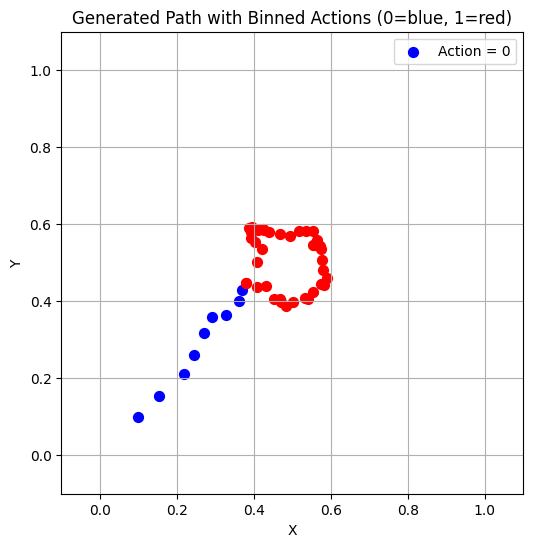

In [44]:
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from LangPathModel.colab_src.textEncoders import TextEncoder
from transformers import AutoTokenizer

d_model = 128
model = TrajectoryModel(d_model=128, num_heads_decoder=4, num_decoder_layers=4)

# Step 2: Load the saved state dict
model.load_state_dict(torch.load("model_state_dict_num_p_20.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))

# Step 3: Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.positional_encoding = model.positional_encoding.to(device)  # This line was added

# Initialize tokenizer and encoder
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = TextEncoder(output_dim=d_model)

# Text and encoding
text = "draw circle"
encoded = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

# **Instead of directly using text_encoder output, use encoded['input_ids'] and encoded['attention_mask']**
# txt = text_encoder(encoded['input_ids'], encoded['attention_mask'])
txt = encoded['input_ids'].to(device)
txt_mask = (encoded['attention_mask'] == 0).to(device)


path_mask = torch.Tensor([[1]]).to(device)

# Iniptialize starting point
start = torch.Tensor([[[0.1, 0.1, 0, 0]]]).to(device)  # (1, 1, 4)
#tgt = torch.empty([1, 1, 4]).to(device)  # (1, 1, 4)
tgt = start
# Store predictions
positions = [start[0, 0, :2].clone().cpu().numpy()]

# Loop to generate 100 predictions
for i in range(100):
    with torch.no_grad():
        prediction = model(
            text=txt,
            path=start,
            tgt=tgt,
            text_mask=txt_mask,
            path_mask=path_mask
        )  # Output shape: (1, seq_len+1, 4
    next_point = prediction[:, -1, :]  # Get the last predicted point
    #print(next_point)
    positions.append(next_point[0, :2].cpu().numpy())  # Save (x, y)

    # Append next_point to tgt for next prediction
    tgt = torch.cat([tgt, next_point.unsqueeze(1)], dim=1)
    if next_point[0, 3] > 0.12: break
    print(next_point[0, 3])

# Convert predictions to numpy array
positions = np.array(positions)  # shape: (num_points, 2)
actions = tgt[0, :, 2].cpu().numpy()  # shape: (num_points,) - only 'a' values
#print(positions)
# Bin actions
binned_actions = (actions >= 0.5).astype(int)  # 0 if a < 0.5, 1 otherwise

# Plot
plt.figure(figsize=(8, 6))
for i in range(len(positions)):
    x, y = positions[i]
    if binned_actions[i] == 0:
        plt.scatter(x, y,color='blue', label='Action = 0' if i == 0 else "", s=50)
    else:
        plt.scatter(x, y, color='red', label='Action = 1' if i == 0 else "", s=50)

plt.title("Generated Path with Binned Actions (0=blue, 1=red)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()



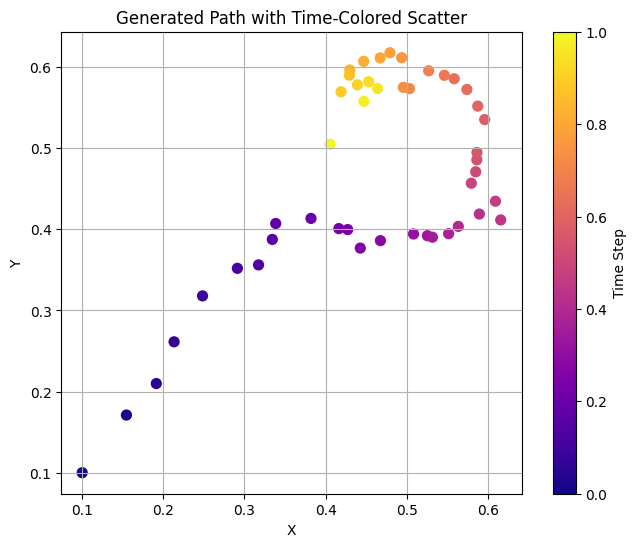

In [23]:
positions = np.array(positions)  # shape: (num_points, 2)
colors = np.linspace(0, 1, len(positions))  # Normalized color values for time

# Scatter plot with color based on time
plt.figure(figsize=(8, 6))
plt.scatter(positions[:, 0], positions[:, 1], c=colors, cmap='plasma', s=50)
plt.colorbar(label="Time Step")
plt.title("Generated Path with Time-Colored Scatter")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()
